In [1]:
# from: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
# np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

# import tensorflow as tf

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K

import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [21]:
# from: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()


In [3]:
# from: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
# load_type: subset means only portion based on subset_frac is loaded
#          : resize means shrinking the images
# train, val and test frac is based on the amount of loaded data.
path = '/home/ubuntu/'
folder = 'skin-cancer-mnist-ham10000'
base_dir = os.path.join(path, folder)
load_type = 'full_resize' # 'subset', 'subset_resize, 'full', 'full_resize'
subset_frac = 0.2
train_frac, val_frac, test_frac = 0.9, 0.05, 0.05

if (load_type == 'subset' or load_type == 'full'):
    img_h = 450
    img_w = 600
elif (load_type == 'subset_resize' or load_type == 'full_resize'):
    img_h = 75
    img_w = 100    

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


In [4]:
# from: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
#Step 3: reading and processing data
csv_filename = 'HAM10000_metadata.csv'
df_curr = pd.read_csv(os.path.join(base_dir, csv_filename))

# Creating New Columns for better readability
df_curr['path'] = df_curr['image_id'].map(imageid_path_dict.get)
df_curr['cell_type'] = df_curr['dx'].map(lesion_type_dict.get) 
df_curr['cell_type_idx'] = pd.Categorical(df_curr['cell_type']).codes
df_curr.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/home/ubuntu/skin-cancer-mnist-ham10000/HAM100...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/home/ubuntu/skin-cancer-mnist-ham10000/HAM100...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/home/ubuntu/skin-cancer-mnist-ham10000/HAM100...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/home/ubuntu/skin-cancer-mnist-ham10000/HAM100...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/home/ubuntu/skin-cancer-mnist-ham10000/HAM100...,Benign keratosis-like lesions,2


In [5]:
# from: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
#Step 4: data cleaning
df_curr.isnull().sum()
df_curr['age'].fillna((df_curr['age'].mean()), inplace=True)
df_curr.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [6]:
# from: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
#Step 6: loading and resizing of images
if (load_type == 'subset'):
    print('subset')
    df_curr = df_curr.sample(frac=subset_frac)
    m_curr = df_curr.shape[0] # percentage of total
    df_curr['image'] = df_curr['path'].map(lambda x: np.asarray(Image.open(x)))
elif (load_type == 'subset_resize'):
    print('subset_resize')
    df_curr = df_curr.sample(frac=subset_frac)
    m_curr = df_curr.shape[0] # percentage of total
    df_curr['image'] = df_curr['path'].map(lambda x: np.asarray(Image.open(x).resize((img_w,img_h))))
elif (load_type == 'full'):
    print("full")
    df_curr = df_curr
    m_curr = df_curr.shape[0] # percentage of total
    df_curr['image'] = df_curr['path'].map(lambda x: np.asarray(Image.open(x)))
elif (load_type == 'full_resize'):
    print("full_resize")
    m_curr = df_curr.shape[0] # percentage of total
    df_curr['image'] = df_curr['path'].map(lambda x: np.asarray(Image.open(x).resize((img_w,img_h))))
    
df_X = df_curr.drop(columns=['cell_type_idx'], axis=1)
df_Y = df_curr['cell_type_idx']

full_resize


In [7]:
# from: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
#Step 7: train test split
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(df_X, df_Y, test_size=test_frac, random_state=1234)

In [8]:

print(x_train.shape)
print(x_train[0].shape)
print(x_test.shape)

NameError: name 'x_train' is not defined

In [9]:
def data_mean_std(data):
    std_list = []
    for i in range(len(data)):
        std_list.append(np.std(data[i]))
    mu = np.mean(data)
    sig = np.mean(np.asarray(std_list))
    return mu, sig

In [10]:
# # from: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
# #Step 8: normalization
mu_train, sig_train = data_mean_std(x_train_o['image'].tolist())
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())
for i in range(x_train.shape[0]):
    x_train[i,:,:,:] = (x_train[i,:,:,:] - mu_train) / sig_train
x_test = (x_test - mu_train) / sig_train

In [11]:
# from: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
#Step 9: label encoding
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [12]:
# from: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
#Step 10: splitting training and validation split
test_frac_train = val_frac / train_frac
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = test_frac_train, random_state = 2)

# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(img_h, img_w, 3))
x_test = x_test.reshape(x_test.shape[0], *(img_h, img_w, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(img_h, img_w, 3))

In [13]:
# from: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
#Step 11: model building, CNN
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

#model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
#model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
#model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


# # from: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
# #Step 11: model building, CNN
# # Set the CNN model 
# # my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
# input_shape = (img_h, img_w, 3)
# num_classes = 7

# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
# # model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
# model.add(MaxPool2D(pool_size = (2, 2)))
# # model.add(Dropout(0.25))

# # model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
# model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# # model.add(Dropout(0.40))

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# #model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))
# model.summary()

W1105 07:21:28.590972 140082397665024 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1105 07:21:28.621680 140082397665024 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1105 07:21:28.628526 140082397665024 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1105 07:21:28.664613 140082397665024 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 59200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               7577728   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [14]:
# from: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
#Step 12: setting optimizer and annealer

# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

W1105 07:21:33.595742 140082397665024 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1105 07:21:33.603338 140082397665024 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [26]:
# from: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
#Step 13: fitting the model

# Fit the model
epochs = 15 
batch_size = 32
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

W1105 07:36:32.188235 140082397665024 deprecation.py:323] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/15
280/280 [==============================] - 124s 444ms/step - loss: 5.5916 - acc: 0.6527 - val_loss: 5.0883 - val_acc: 0.6843
Epoch 2/15
280/280 [==============================] - 124s 441ms/step - loss: 5.3493 - acc: 0.6681 - val_loss: 5.0883 - val_acc: 0.6843
Epoch 3/15
280/280 [==============================] - 123s 440ms/step - loss: 5.3434 - acc: 0.6685 - val_loss: 5.0883 - val_acc: 0.6843
Epoch 4/15
280/280 [==============================] - 123s 439ms/step - loss: 5.3401 - acc: 0.6687 - val_loss: 5.0883 - val_acc: 0.6843

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/15
280/280 [==============================] - 123s 438ms/step - loss: 5.3657 - acc: 0.6671 - val_loss: 5.0883 - val_acc: 0.6843
Epoch 6/15
280/280 [==============================] - 124s 443ms/step - loss: 5.3337 - acc: 0.6691 - val_loss: 5.0883 - val_acc: 0.6843
Epoch 7/15
280/280 [==============================] - 125s 445ms/step - loss: 5.3526 - acc: 0.6679 - va

In [22]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

501/501 [==============================] - 1s 3ms/step
Train: accuracy = 0.115768  ;  loss = 1.887720
Validation: accuracy = 0.270321  ;  loss_v = 9.835708
Test: accuracy = 0.115768  ;  loss = 1.887720


Text(87.02500000000006, 0.5, 'Fraction classified incorrectly')

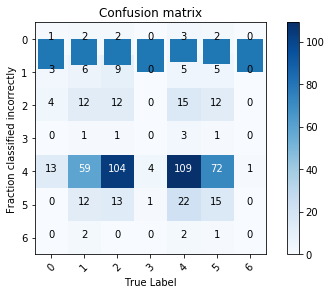

In [25]:
# from: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
#Step 14: model evaluation
loss_t, accuracy_t = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy_t, loss_t,))
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model_part1.h5")

#plot_model_history(history)


# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plot_confusion_matrix(confusion_mtx, classes = range(len(label_frac_error))) 
plt.bar(np.arange(len(label_frac_error)),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')